In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from functools import reduce
import glob

In [9]:
glob.glob(r'C:\Users\diego\Downloads\Test\dato_*.xlsx')     #Path folder of ur stations data

['C:\\Users\\diego\\Downloads\\Test\\dato_AASANA.xlsx',
 'C:\\Users\\diego\\Downloads\\Test\\dato_tambo.xlsx']

In [10]:
def remove_low_data_months(df, date_column, threshold):

    # Convert the date_column to datetime format if it's not already
    #df[date_column] = pd.to_datetime(df[date_column])

    # Group by month and calculate the percentage of available data
    monthly_data = df.groupby(df[date_column].dt.to_period('M')).count().rename(columns = {'Fecha':'count'})
    monthly_data.reset_index(inplace=True)
    monthly_data['percentage'] = monthly_data.iloc[:,2] / df[date_column].dt.days_in_month * 100

    # Identify months with less than the threshold percentage
    low_data_months = monthly_data[monthly_data['percentage'] < threshold]

    # Filter the original dataframe to exclude the identified months
    filtered_df = df[~df['Fecha'].dt.to_period('M').astype(str).isin(low_data_months['Fecha'].astype(str))]

    return filtered_df

In [11]:
all_dfs = []
all_stations_name = []

for one_filename in glob.glob(r'C:\Users\diego\Downloads\Test\dato_*.xlsx'):
    df = pd.DataFrame(pd.read_excel(one_filename))
    #df.loc[:,'Fecha'] = pd.to_datetime(df.gestion.astype(str)+'-'+df.mes.astype(str))   #if monthly data
    df.loc[:,'Fecha'] = pd.to_datetime(df.gestion.astype(str)+'-'+df.mes.astype(str) +'-'+df.dia.astype(str))   #if daily data
    station_name = df['estacion'][0]
    df[station_name] = df.loc[:, ['Precipitación']]
    df= df.loc[:, ['Fecha', station_name]]
    df = remove_low_data_months(df, 'Fecha', threshold=30)
    df.set_index('Fecha', inplace = True)
    all_dfs.append(df)
    all_stations_name.append(station_name)

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Fecha'],
                                            how='outer'), all_dfs)

Data_av = pd.DataFrame(df_merged.resample('Y').count())
Data_pivot =pd.pivot_table(Data_av, columns= Data_av.index.year)

Text(0.5, 1.0, 'Disponibilidad de datos de precipitación por estación en la zona de estudio')

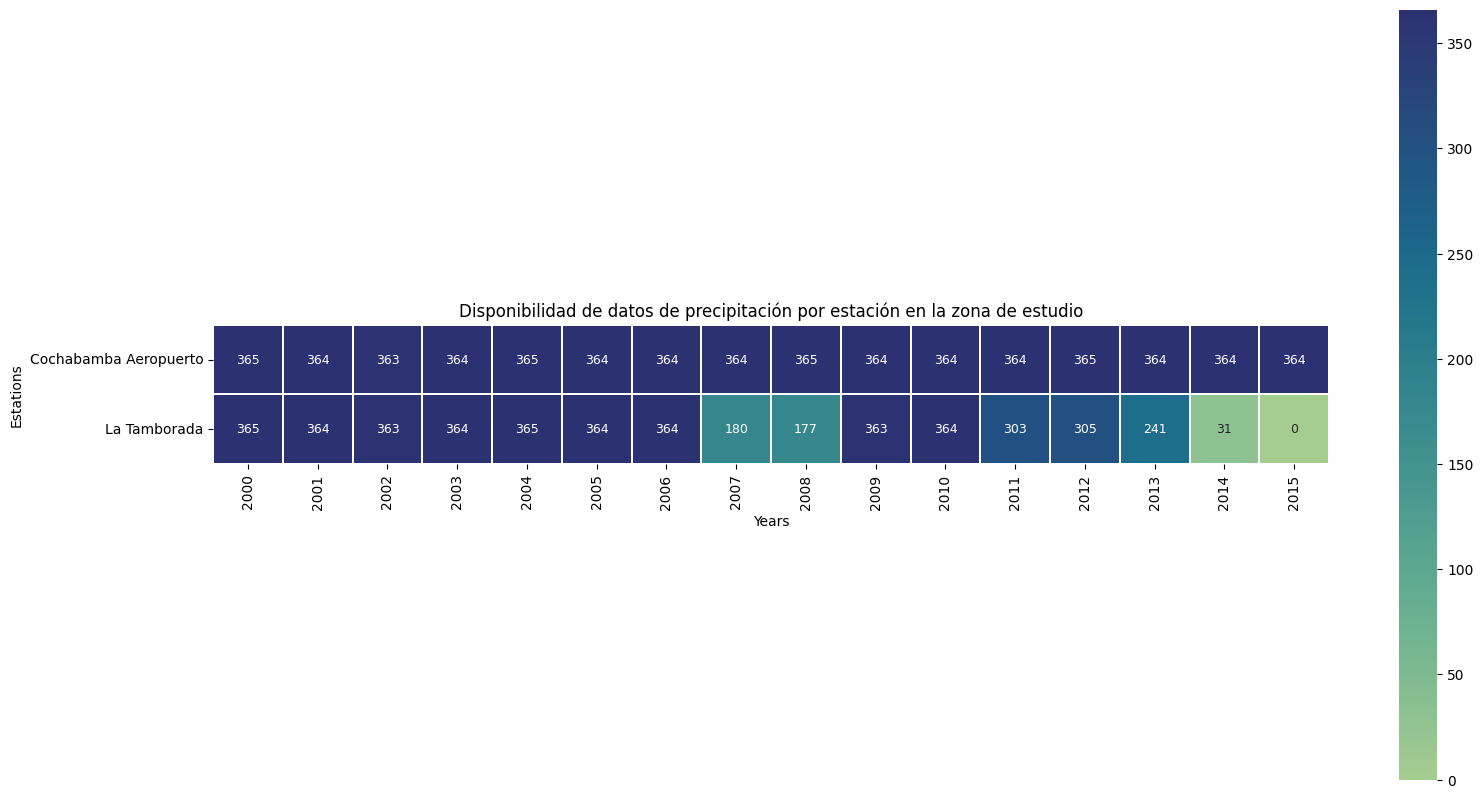

In [12]:
plt.figure(figsize= (18,10))
s = sns.heatmap(Data_pivot, annot= True, fmt= '.0f', linewidths = 0.1, square = True, vmin= 0, vmax= 366,
                annot_kws= {
                    'fontsize': 9
                }, cmap='crest')
s.set(xlabel = 'Years', ylabel= 'Estations')
plt.xticks(rotation = 90)
plt.title('Disponibilidad de datos de precipitación por estación en la zona de estudio')

In [13]:
#Choose as many stations u wanna analyze as u want
df = df_merged
#Creating an empy data frame to fill index values in date
starting_date = df.index.min()
ending_date = df.index.max()
date_range = pd.date_range(start= starting_date, end= ending_date, freq = 'MS')
df_empty = pd.DataFrame(0, columns = ['Precipitation [mm]'], index = date_range)
df_empty.index.names = ['Fecha']

#Merge and leave the main df with NaN values 
df_main = pd.merge(df_empty, df, on = 'Fecha', how = 'outer')
df_main.sort_values(by= 'Fecha', inplace = True)
df = df_main.drop(['Precipitation [mm]'], axis=1)
df = df.rename_axis(index = None)
df

,Cochabamba Aeropuerto,La Tamborada
2000-01-01,0.0,0.6
2000-01-02,0.1,0.0
2000-01-03,0.0,0.0
2000-01-04,8.6,1.8
2000-01-05,2.7,3.6
...,...,...
2015-12-27,0.0,NaN
2015-12-28,0.0,NaN
2015-12-29,11.1,NaN
2015-12-30,1.6,NaN


Monthly precipitation

In [14]:
x = (df.groupby(by=[df.index.year, df.index.month]).mean()*df.groupby(by=[df.index.year, df.index.month]).count()).reset_index()
x['idx'] = x.groupby((x.level_1 == 8).cumsum())['level_0'].transform(
    lambda x: "/".join(map(str, x.unique()))
)
out = (
    x.pivot_table(index='idx', columns='level_1', values= 'Cochabamba Aeropuerto')      #Change ur station
    .rename_axis(index=None, columns=None)
)
out = out[sorted(out.columns, key=lambda c: c + 100 if c < 8 else c)]
out.columns = [calendar.month_abbr[c] for c in out.columns]
df2 = pd.DataFrame(out)
Monthly_pr = pd.DataFrame(df2.assign(Total_Year=df2.sum(axis=1)))
Monthly_pr = Monthly_pr[1:-1]
Monthly_pr

,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Total_Year
2000/2001,0.1,23.6,15.1,19.5,92.1,174.2,81.6,73.1,10.9,13.0,0.0,1.1,504.3
2001/2002,14.5,0.2,22.0,14.9,117.3,35.1,151.2,49.5,22.5,2.8,0.0,6.1,436.1
2002/2003,1.4,0.2,23.3,23.9,15.1,115.0,72.4,75.4,0.7,0.1,0.0,0.1,327.6
2003/2004,1.9,4.0,48.0,12.1,162.0,184.9,134.6,16.8,25.1,4.7,0.3,5.2,599.6
2004/2005,0.2,13.7,0.4,83.0,70.7,107.5,94.2,2.5,25.3,4.7,0.0,0.0,402.2
2005/2006,0.0,6.4,12.6,105.9,88.6,161.3,66.9,99.3,34.8,0.0,0.4,0.0,576.2
2006/2007,0.7,1.2,18.2,47.8,57.9,83.3,75.3,61.3,23.3,0.2,0.0,0.0,369.2
2007/2008,0.0,0.0,10.4,87.3,114.7,160.6,98.7,77.8,31.2,1.7,2.9,0.0,585.3
2008/2009,0.6,5.6,10.9,31.2,93.6,49.6,108.7,56.5,39.0,0.1,0.0,7.5,403.3
2009/2010,0.2,3.9,31.1,41.7,66.6,73.7,81.1,68.4,0.0,0.1,0.0,0.4,367.2


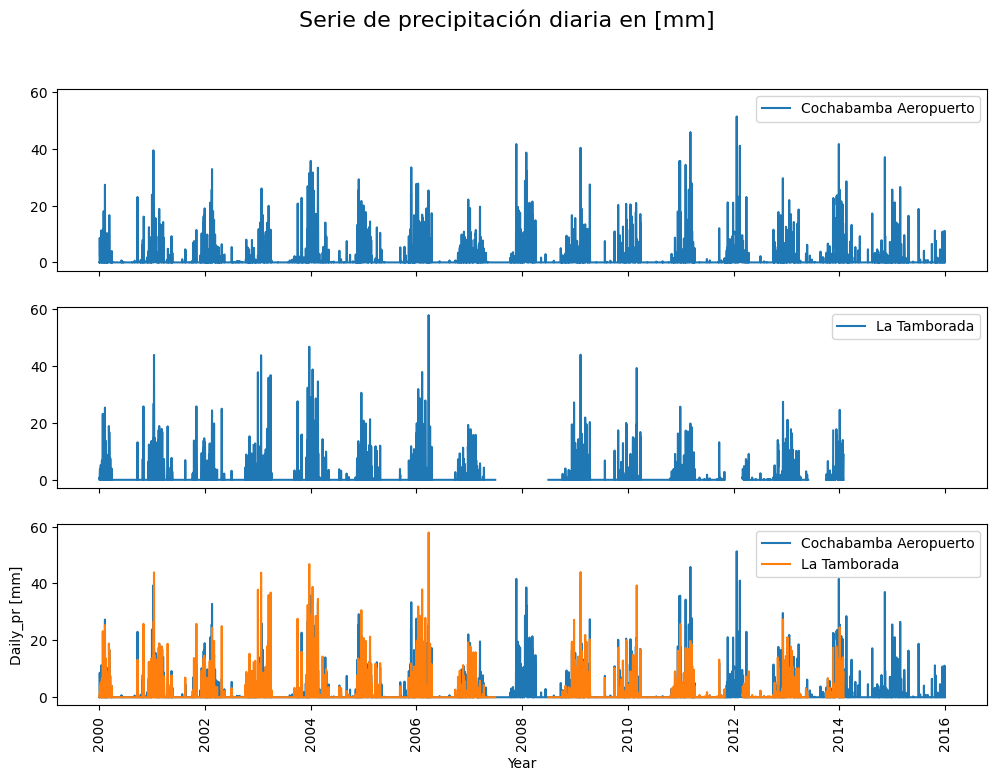

In [65]:
fig, axs=plt.subplots(3,1,figsize=(12,8),sharex= True,sharey= True)
axs[0].plot(df.index,df[all_stations_name[0]],label= all_stations_name[0])
axs[0].legend()
axs[1].plot(df.index,df[all_stations_name[1]],label=all_stations_name[1])
axs[1].legend()
axs[2].plot(df.index, df[all_stations_name[0]], df[all_stations_name[1]])
axs[2].legend(all_stations_name)
plt.xticks(rotation='vertical')
plt.ylabel('Daily_pr [mm]')
plt.xlabel('Year')
fig.suptitle('Serie de precipitación diaria en [mm]', fontsize = 16)
plt.show()

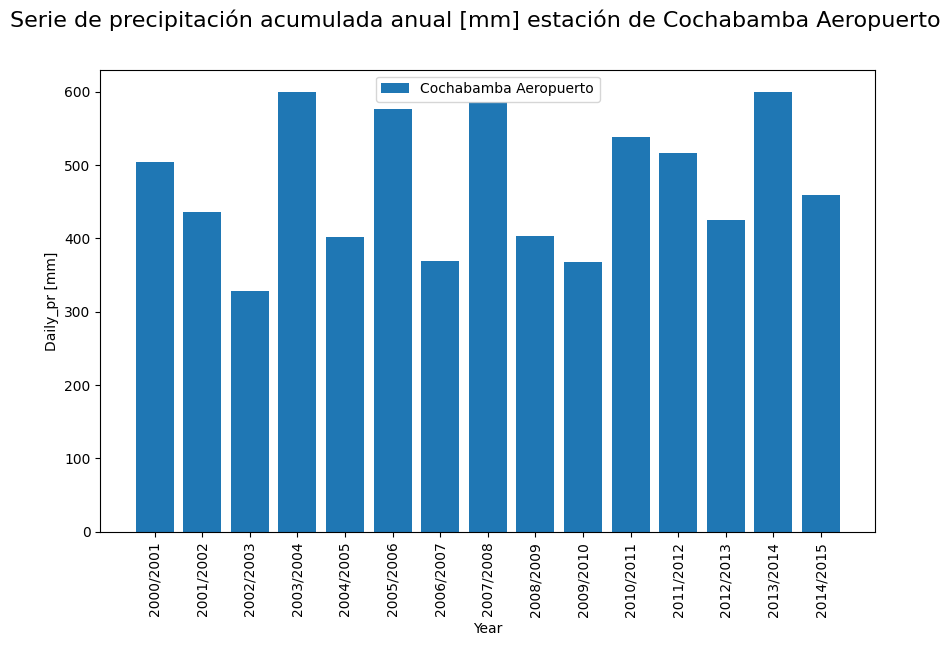

In [66]:
fig, axs=plt.subplots(1,1,figsize=(10,6),sharex= True,sharey= True)
axs.bar(Monthly_pr.index,Monthly_pr['Total_Year'],label=all_stations_name[0])
axs.legend()
plt.xticks(rotation='vertical')
plt.ylabel('Daily_pr [mm]')
plt.xlabel('Year')
fig.suptitle('Serie de precipitación acumulada anual [mm]' + ' estación de ' + all_stations_name[0], fontsize = 16)
plt.show()

Cochabamba Aeropuerto       Axes(0.125,0.11;0.352273x0.77)
La Tamborada             Axes(0.547727,0.11;0.352273x0.77)
dtype: object

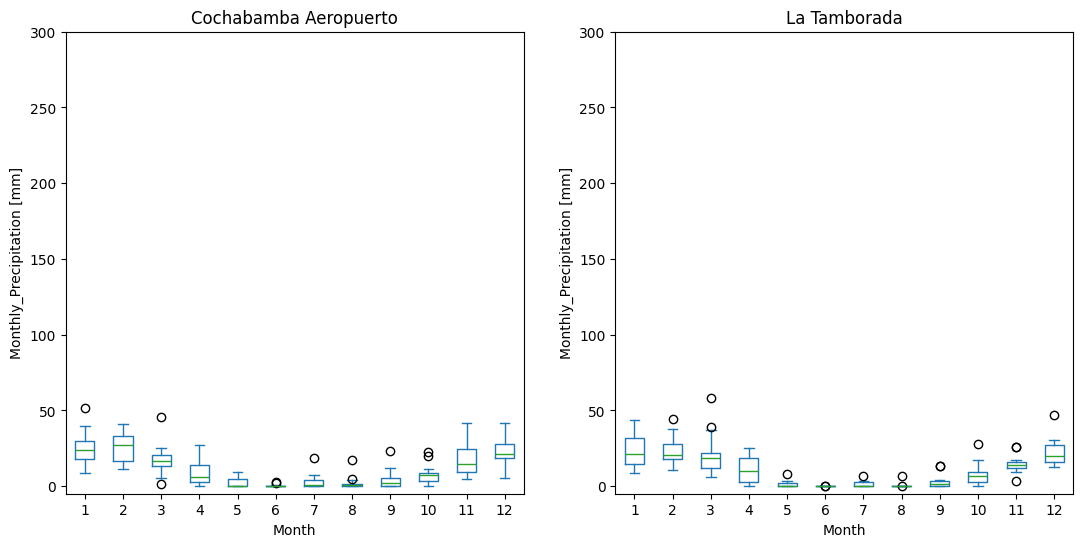

In [67]:
x.plot.box(by= 'level_1', column= [all_stations_name[0], all_stations_name[1]],figsize = (13,6), xlabel = 'Month', 
           ylabel= 'Monthly_Precipitation [mm]', ylim= (-5, 300) )

Daily precipitation

In [68]:
x = df.groupby(by=[df.index.year, df.index.month]).max().reset_index()

x['idx'] = x.groupby((x.level_1 == 8).cumsum())['level_0'].transform(
    lambda x: "/".join(map(str, x.unique()))
)

In [69]:
out = (
    x.pivot_table(index='idx', columns='level_1', values='Cochabamba Aeropuerto')      #Change ur station
    
    .rename_axis(index=None, columns=None)
)
out = out[sorted(out.columns, key=lambda c: c + 100 if c < 8 else c)]
out.columns = [calendar.month_abbr[c] for c in out.columns]
df2 = pd.DataFrame(out)
df2
Max_Year = pd.DataFrame(df2.assign(Max_Year=df2.max(axis=1)))
Max_Year[1:-1]

,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Max_Year
2000/2001,0.1,23.0,7.9,16.1,23.8,39.4,18.8,14.2,4.8,9.2,0.0,1.1,39.4
2001/2002,4.6,0.1,7.5,11.4,19.0,9.8,32.8,14.9,6.4,2.8,0.0,5.4,32.8
2002/2003,0.5,0.2,8.0,7.9,5.1,26.0,16.7,19.9,0.7,0.1,0.0,0.1,26.0
2003/2004,1.0,2.2,22.7,4.9,31.4,35.7,33.3,5.5,14.0,4.5,0.3,4.1,35.7
2004/2005,0.1,7.5,0.4,29.2,21.6,17.7,14.4,1.4,12.3,4.5,0.0,0.0,29.2
2005/2006,0.0,5.3,5.5,33.4,27.6,27.7,16.8,25.3,17.3,0.0,0.4,0.0,33.4
2006/2007,0.7,0.7,6.1,10.8,22.1,19.1,11.4,19.6,7.7,0.2,0.0,0.0,22.1
2007/2008,0.0,0.0,3.6,41.6,19.5,38.6,32.2,21.4,14.8,1.7,2.9,0.0,41.6
2008/2009,0.6,5.0,3.2,9.4,16.6,15.6,40.3,13.4,27.4,0.1,0.0,7.5,40.3
2009/2010,0.2,3.3,20.2,12.6,20.6,20.4,20.9,17.0,0.0,0.1,0.0,0.3,20.9


Cochabamba Aeropuerto       Axes(0.125,0.11;0.352273x0.77)
La Tamborada             Axes(0.547727,0.11;0.352273x0.77)
dtype: object

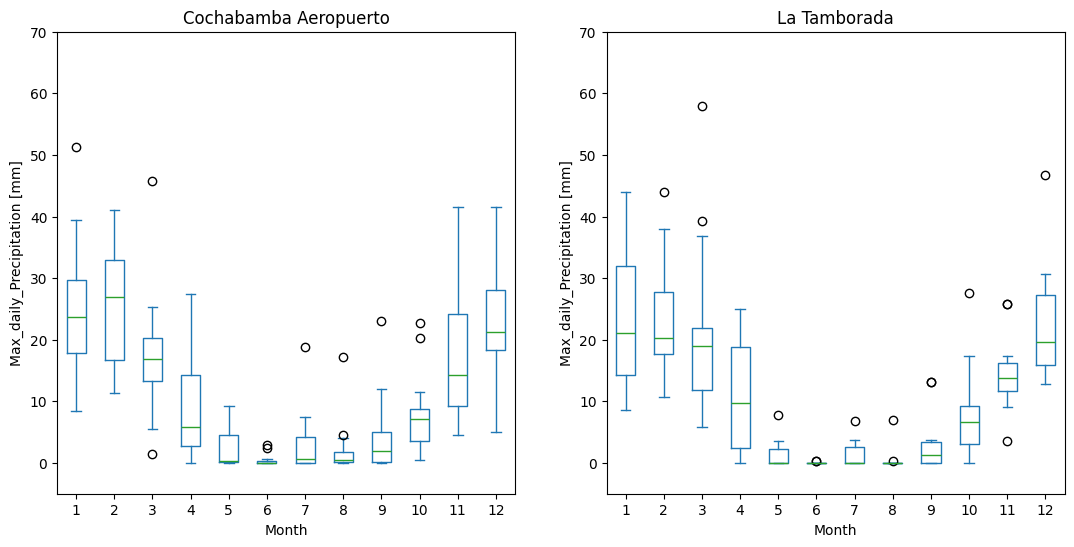

In [70]:
x.plot.box(by= 'level_1', column= [all_stations_name[0], all_stations_name[1]],figsize = (13,6), xlabel = 'Month', 
           ylabel= 'Max_daily_Precipitation [mm]', ylim= (-5,70))

In [71]:
with pd.ExcelWriter('Multi_stations_analysis.xlsx') as writer:
    Monthly_pr.to_excel(writer, sheet_name ='Monthly_pr')
    Max_Year.to_excel(writer, sheet_name = 'Max_Year')